# CommonLit Readability Challenge - Word2Vec + UMAP 🗺️
## Introduction 

In this notebook we are going to see how to apply a pretrained [Word2Vec](https://jalammar.github.io/illustrated-word2vec/) model (from gensim) to a text corpus of our choice and,after that, we are going to see if our embedding has captured readability by employing a dimensionality reduction algorithm named [UMAP](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html).

``` If you're trying to locally install umap, pay attention to the fact that the correct command is "pip install umap-learn", indeed it is "import umap" while importing it```.


In [1]:
import pandas as pd 
import numpy as np
import re 

import nltk
#nltk.download('punkt')

# model imports
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api # we need an internet connection for this one 

from sklearn.model_selection import train_test_split

# visualization imports
import umap # nonlinear dimensionality reduction
import matplotlib.pyplot as plt
%matplotlib inline

### Utilities
Here some utility functions: 
* ```remove_ascii_words``` it might be useless in this case but it's quite useful for general purpose preprocessing, where we don't know whether there are non-ascii characters around

* ```get_good_tokens``` removes useless punctuation

* ``` w2v_preprocessing``` all the necessary preprocessing for gensim Word2Vec model, we basically divide each document into individual sentences, remove punctuation by using ```get_good_tokens```, tokenize every sentence and remove empty lists. 


In [2]:
our_special_word = 'qwerty'

def remove_ascii_words(df):
    """ removes non-ascii characters from the 'texts' column in df.
    It returns the words containig non-ascii characers.
    """
    non_ascii_words = []
    for i in range(len(df)):
        for word in df.loc[i, 'excerpt'].split(' '):
            if any([ord(character) >= 128 for character in word]):
                non_ascii_words.append(word)
                df.loc[i, 'excerpt'] = df.loc[i, 'excerpt'].replace(word, our_special_word)
    return non_ascii_words

In [3]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [4]:
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['excerpt'] = df.excerpt.str.lower()
    df['document_sentences'] = df.excerpt.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
   # df['tokenized_sentences'] = list(map(lambda sentences: list(map( ,sentences)), df.tokenized_sentences))
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

### Data Import
Let's load training data as a ```pandas``` dataframe

In [5]:
train_data =  pd.read_csv("../input/commonlitreadabilityprize/train.csv")
train_data.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [6]:
train_data.excerpt = train_data['excerpt'].apply(str)
non_ascii_words = remove_ascii_words(train_data)

print("Replaced {} words with characters with an ordinal >= 128 in the test data.".format(
    len(non_ascii_words)))

Replaced 1327 words with characters with an ordinal >= 128 in the test data.


### Pretrained Word2Vec
Here we can load a pretrained version of Word2Vec (on Google News) from ```Gensim```'s API. Each vector has 300 components

In [7]:
W2Vmodel = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


## Preprocessing

Here we apply our utility functions for preprocessing

In [8]:
w2v_preprocessing(train_data)

In [9]:
train_data.drop(train_data[train_data.tokenized_sentences.str.len() == 0].index, inplace= True) 

In [10]:
#create dictionary with all sentences
sentences = []
for sentence_group in train_data.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(train_data)))

Number of sentences: 25633.
Number of texts: 2834.


## Feature Extraction

The following function, ```get_w2v_features``` transforms each sentence into a feature vector by averaging words vectors. In this way we can take into account the different length of each sentence, on the other side, by averaging on different words we will lose some word-specific information.

In [11]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.index_to_key) # set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

Extracting Word2Vec features as a dataframe column. This cell takes quite a lot of time (~1 hr), it might be useful to parallelize the feature extraction process, you know nested ```for``` loops are always problematic in Python 🐍

In [12]:
train_data['w2v_features'] = list(map(lambda sen_group:
                                     get_w2v_features(W2Vmodel, sen_group),
                                     train_data.tokenized_sentences))

train_data["w2v_resh_features"] = train_data["w2v_features"].apply(lambda x : x.reshape(1,-1) )

In [13]:
# save w2v features
#train_data.to_csv("w2v_features.csv")

Converting Word2Vec features to ```numpy.ndarray``` for visualization purposes with ```UMAP```


In [14]:
arr_w2v = train_data.w2v_resh_features[0]
for i in range(1, len(train_data)):
    arr_w2v = np.vstack((arr_w2v, train_data.w2v_resh_features[i]))

# Dimensionality Reduction and Visualization via UMAP

```UMAP``` is a nonlinear dimensionality reduction technique, something like ```PCA``` but more fancy! 
It can be used for both *unsupervised* and *supervised* problems and also both for *regression* and *classification* problems.   

Since we are facing a regression problem, i.e. our target variable is continuous, we have to impose ```target_metric = 'l1'``` (thanks Leland McInnes, here a [github issue ](https://github.com/lmcinnes/umap/issues/257) as motivation). 
We opted for a 2-dimensional representation (```n_components = 2```) 

In [15]:
umap_emb = umap.UMAP(n_neighbors= 15, n_components = 2, target_metric = 'l1' , n_epochs = 500).fit_transform(arr_w2v, y=train_data.target)

Let's take a look at what we get by plotting this new 2-d space.

[None, None, None, None, None, None, None, None, None, None]

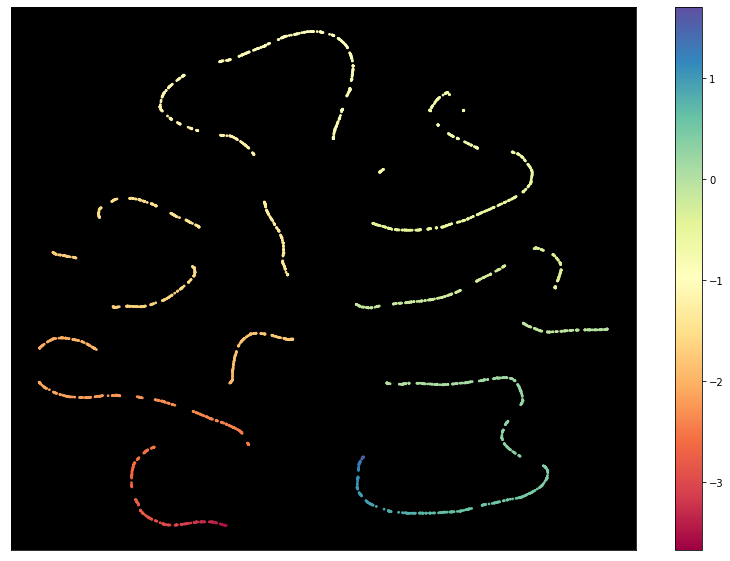

In [16]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*umap_emb.T, s=3, c=train_data.target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
ax.patch.set_facecolor('black')
fg_color = 'black'
cbar = plt.colorbar()
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=fg_color)

Okay, in a supervised setting ```UMAP``` is able to isolate this structure, i.e. it seems that there exist a specific subspace which is kinda parametrized by the **readability target**. Is it possible to find a similar structure in a semi-supervised or unsupervised setting? Let's dive in 🏊🤿

## Validation Set

Let's use ```scikit-learn```'s ```train_test_split``` method in order to extract a validation set and try to see whether a semi-supervised ```UMAP``` can capture some structures.

In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    arr_w2v, train_data[["target", "standard_error"]].values, test_size=0.10, random_state=42)

In [18]:
mapper = umap.UMAP(n_neighbors= 15, n_components = 2, target_metric = 'l1' , n_epochs = 1000).fit(X_train, y=y_train[:,0])

In [19]:
val_embedding = mapper.transform(X_val)

[None, None, None, None, None, None, None, None, None, None]

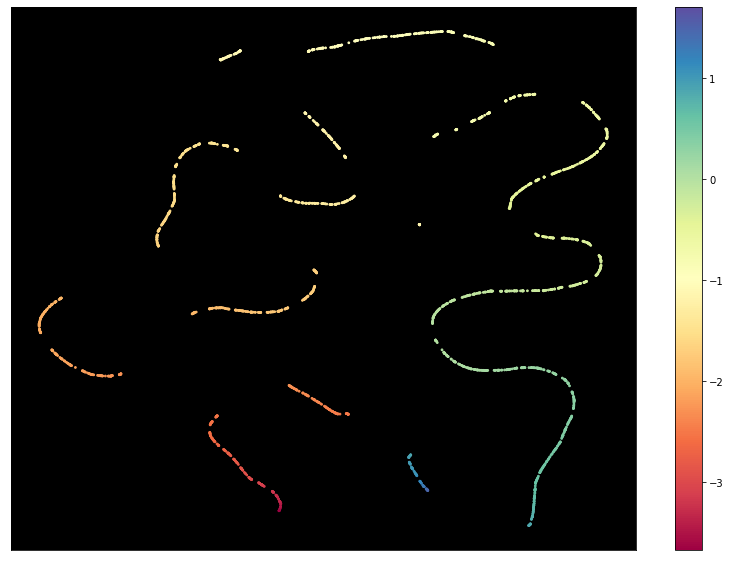

In [20]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper.embedding_.T, s=3, c=y_train[:,0], cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
ax.patch.set_facecolor('black')
fg_color = 'black'
cbar = plt.colorbar()
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=fg_color)

[None, None, None, None, None, None, None, None, None, None]

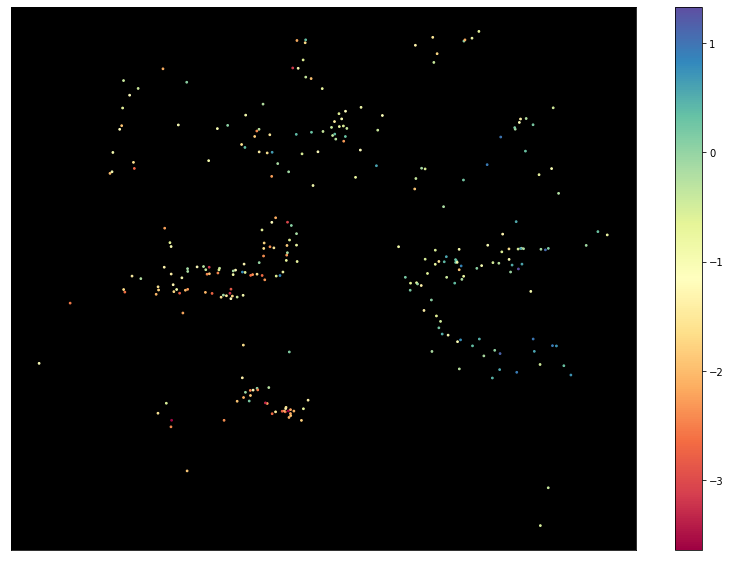

In [21]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*val_embedding.T, s=3, c=y_val[:,0], cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
ax.patch.set_facecolor('black')
fg_color = 'black'
cbar = plt.colorbar()
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=fg_color)

Unfortunately the result is not what we wanted it to be. Anyway, a further investigation of the supervised representation extracted by ```UMAP``` is worth to be done even by considering it for augmentation strategies

# XGBoost on W2V features

Here we apply a ```XGBoost``` regressor on our Word2Vec features,  in order to be ready for submission

In [22]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse

In [23]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 1000, verbosity = 1)

xg_reg.fit(X_train,y_train[:,0])

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [24]:
preds = xg_reg.predict(X_val)

~0.69 not bad, let's see on test :) 

In [25]:
np.sqrt(mse(y_val[:,0], preds)) 

0.656116743177399

# W2V Naive Augmentation 

In this section, we'll try to instantiate a naive augmentation pipeline for Word2Vec features. The rationale behind the following strategy is that W2V features are essentially vectors so we can augment our "feature set" by perturbing these vectors with a small gaussian noise, in order to facilitate the learning procedure for our regressor of choice. Moreover, we'd like to see if by augmenting our "feature set" in this way we can **break** the structure extracted by the supervised ```UMAP```.

Of course, this naive augmentation doesn't make a lot of sense from a word/sentence perspective
since it might be that the perturbed vectors don't correspond to any word/sentence themselves.

With the following method, ```augment_train_w2v```, we augment the training set by adding a small gaussian noise on w2v's features while slightly modifying (by exploiting the **standard deviation** of each target) the new target variable corresponding to the augmented sample.

In [26]:
def augment_train_w2v(X_train, y_train, y_std, times = 5):
    
    augmented_w2v_X = X_train.copy()
    augmented_w2v_y = y_train.copy()
    
    for j in range(0, times - 1):
        for i in range(0, X_train.shape[0]):
        
            new_w2v = X_train[i,:] + np.random.uniform(1,8)*1e-4*np.random.randn(300)       # np.random.uniform(1,8)*1e-3*np.random.randn(300)
            augmented_w2v_X = np.vstack((augmented_w2v_X, new_w2v))
            
            new_y = y_train[i] + np.random.choice([-1, 1])*y_std[i]*0.05
            augmented_w2v_y = np.append(augmented_w2v_y, new_y)
        
    return augmented_w2v_X, augmented_w2v_y

In [27]:
aug_X_train, aug_Y_train = augment_train_w2v(X_train, y_train[:,0], y_train[:,1], times = 5)

We decided to shuffle again the new augmented training set by keeping the information on the sample-target couple. That's what the following method ```shuffle_couples``` does. 

In [28]:
def shuffle_couples(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [29]:
aug_X_train, aug_Y_train = shuffle_couples(aug_X_train, aug_Y_train)

Now let's see if the previously seen structure still exist ( you can try to change the parameter ```times``` of ```augment_train_w2v``` to see weather it affects something or not) 

In [30]:
mapper_2 = umap.UMAP(n_neighbors= 15, n_components = 2, min_dist = 0.1, target_metric = 'l1' , n_epochs = 1000).fit(aug_X_train)#, y=aug_Y_train)

In [31]:
val_embedding_2 = mapper_2.transform(X_val)

[None, None, None, None, None, None, None, None, None, None]

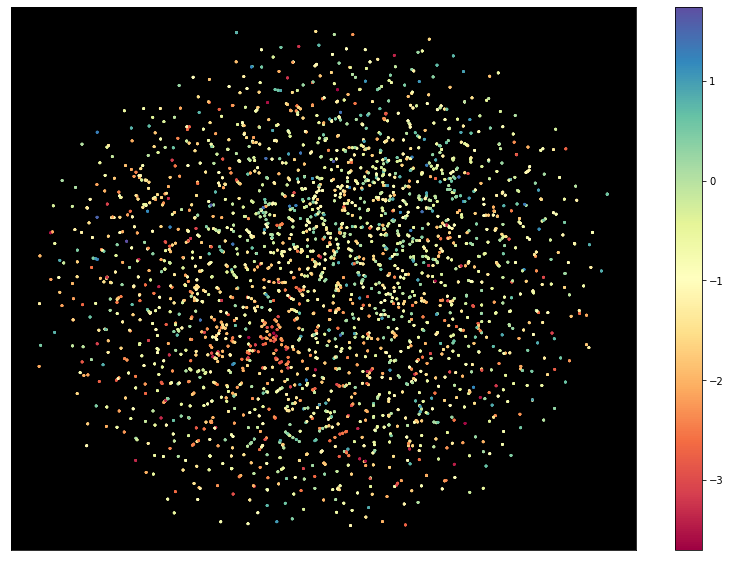

In [32]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper_2.embedding_.T, s=3, c=aug_Y_train, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
ax.patch.set_facecolor('black')
fg_color = 'black'
cbar = plt.colorbar()
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=fg_color)

[None, None, None, None, None, None, None, None, None, None]

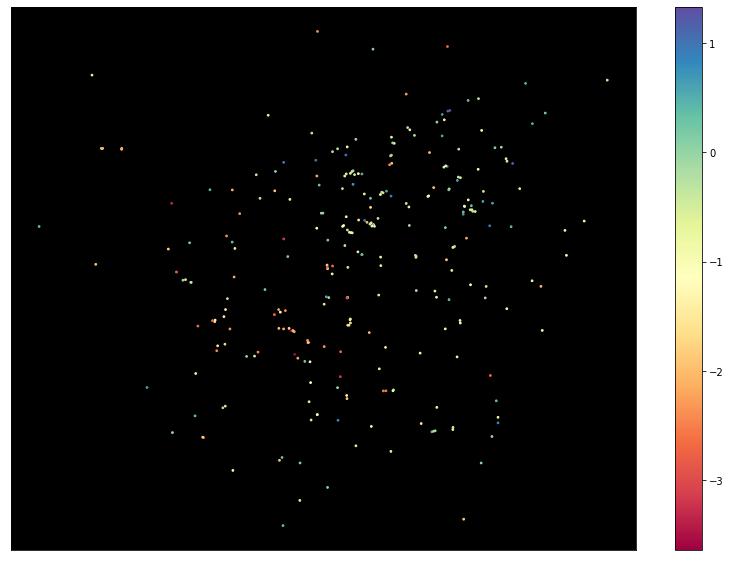

In [33]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*val_embedding_2.T, s=3, c=y_val[:,0], cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
ax.patch.set_facecolor('black')
fg_color = 'black'
cbar = plt.colorbar()
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=fg_color)

Apparently the structure is affected by this augmentation strategy. After that we can take a look at the ```rmse``` score, maybe we can get a better result

In [34]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 1000, verbosity = 1)

xg_reg.fit(aug_X_train, aug_Y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [35]:
preds = xg_reg.predict(X_val)

In [36]:
np.sqrt(mse(y_val[:,0], preds))

0.6792162014766102

The result is pretty much the same, we need to devise a better augmentation strategy, maybe by exploiting the information gained with ```UMAP```


# Test Data

Preparing submission with test data by basically re-doing the previously seen operations.

In [37]:
test_data =  pd.read_csv("/kaggle/input/commonlitreadabilityprize/test.csv")
test_data.head()

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [38]:
test_data.excerpt = test_data['excerpt'].apply(str)
non_ascii_words = remove_ascii_words(test_data)

print("Replaced {} words with characters with an ordinal >= 128 in the test data.".format(
    len(non_ascii_words)))

Replaced 0 words with characters with an ordinal >= 128 in the test data.


In [39]:
w2v_preprocessing(test_data)

In [40]:
test_data.drop(test_data[test_data.tokenized_sentences.str.len() == 0].index, inplace= True) 

In [41]:
#create dictionary with all sentences
sentences_test = []
for sentence_group in test_data.tokenized_sentences:
    sentences_test.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(test_data)))

Number of sentences: 25633.
Number of texts: 7.


In [42]:
test_data['w2v_features'] = list(map(lambda sen_group:
                                     get_w2v_features(W2Vmodel, sen_group),
                                     test_data.tokenized_sentences))

In [43]:
test_data["w2v_resh_features"] = test_data["w2v_features"].apply(lambda x : x.reshape(1,-1) )

In [44]:
arr_w2v_test = test_data.w2v_resh_features[0]
for i in range(1, len(test_data)):
    arr_w2v_test = np.vstack((arr_w2v_test, test_data.w2v_resh_features[i]))